## Importing Necessary Libraries

In [17]:
import os
import patoolib
from warnings import filterwarnings
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.types as ptypes
import pyspark.sql.functions as funcs

filterwarnings("ignore")

In [18]:
patoolib.extract_archive("sales analysis.zip")

INFO patool: Extracting sales analysis.zip ...
INFO patool: ... sales analysis.zip extracted to `SalesAnalysis.csv'.


'SalesAnalysis.csv'

In [19]:
spark = SparkSession.builder.appName("Spark").config("spark_option", "value").getOrCreate()

## About the Dataset

* In this dataset we need to analyse the sales for an Electronics store. This dataset consists of sales details for an entire year 

## Reading the dataset

In [23]:
sales_data = spark.read.csv("SalesAnalysis.csv", inferSchema=True, header=True)
sales_data.show()

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  176558|USB-C Charging Cable|               2|     11.95|04/19/19 08:46|917 1st St, Dalla...|
|    NULL|                NULL|            NULL|      NULL|          NULL|                NULL|
|  176559|Bose SoundSport H...|               1|     99.99|04/07/19 22:30|682 Chestnut St, ...|
|  176560|        Google Phone|               1|     600.0|04/12/19 14:38|669 Spruce St, Lo...|
|  176560|    Wired Headphones|               1|     11.99|04/12/19 14:38|669 Spruce St, Lo...|
|  176561|    Wired Headphones|               1|     11.99|04/30/19 09:27|333 8th St, Los A...|
|  176562|USB-C Charging Cable|               1|     11.95|04/29/19 13:03|381 Wilson St, Sa...|
|  176563|Bose SoundSport H...|         

## EDA

### 1. Shape of dataset

In [25]:
print(f"Dataset has {sales_data.count()} rows and {len(sales_data.columns)} columns")

Dataset has 186850 rows and 6 columns


### 2. Dropping null rows amd checking the shape of the new Data Frame

In [78]:
sales_data_dropna = sales_data.dropna()
print(f"Dataset has {sales_data_dropna.count()} rows and {len(sales_data_dropna.columns)} columns")

Dataset has 185950 rows and 6 columns


### 3. Cleaning `Order Date` column

In [79]:
# Converting the date columns into hour, minute, day_of_the_week and month_ordered
sales_data_dropna = (sales_data_dropna.
                     withColumn('Order Date', funcs.from_unixtime(funcs.unix_timestamp('Order Date', 'MM/dd/yy HH:mm'))))
sales_data_dropna = (sales_data_dropna
                     .withColumn('hour', funcs.date_format(sales_data_dropna['Order Date'], 'HH').cast(ptypes.IntegerType()))
                     .withColumn('minute', funcs.date_format(sales_data_dropna['Order Date'], 'mm').cast(ptypes.IntegerType()))
                     .withColumn('day_of_the_week', funcs.date_format(sales_data_dropna['Order Date'], 'EEEE'))
                     .withColumn('month_ordered', funcs.date_format(sales_data_dropna['Order Date'], 'MMM')))

In [80]:
sales_data_dropna.show(5)

+--------+--------------------+----------------+----------+-------------------+--------------------+----+------+---------------+-------------+
|Order ID|             Product|Quantity Ordered|Price Each|         Order Date|    Purchase Address|hour|minute|day_of_the_week|month_ordered|
+--------+--------------------+----------------+----------+-------------------+--------------------+----+------+---------------+-------------+
|  176558|USB-C Charging Cable|               2|     11.95|2019-04-19 08:46:00|917 1st St, Dalla...|   8|    46|         Friday|          Apr|
|  176559|Bose SoundSport H...|               1|     99.99|2019-04-07 22:30:00|682 Chestnut St, ...|  22|    30|         Sunday|          Apr|
|  176560|        Google Phone|               1|     600.0|2019-04-12 14:38:00|669 Spruce St, Lo...|  14|    38|         Friday|          Apr|
|  176560|    Wired Headphones|               1|     11.99|2019-04-12 14:38:00|669 Spruce St, Lo...|  14|    38|         Friday|          Apr|

### 4. Total number of products sold per month

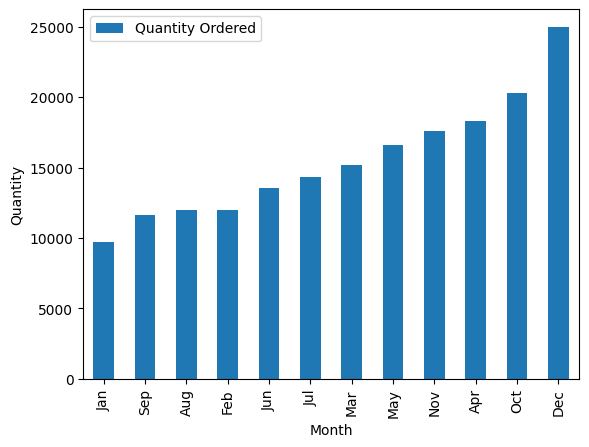

In [81]:
(sales_data_dropna.groupby('month_ordered')
 .agg(
     funcs.count(funcs.col('Quantity Ordered')).alias('Quantity Ordered')
 ).sort("Quantity Ordered").toPandas().plot(kind='bar', x='month_ordered', xlabel="Month", ylabel='Quantity')
)
plt.show()

### 5. Sales per month

In [82]:
sales_data_dropna = sales_data_dropna.withColumn('total_pay', (funcs.col('Price Each') * funcs.col('Quantity Ordered')))
monthly_highest_sales = sales_data_dropna.groupby('month_ordered').sum('total_pay').alias('monthly_total').sort("sum(total_pay)")
monthly_highest_sales = monthly_highest_sales.withColumnRenamed('sum(total_pay)', 'monthly_total')

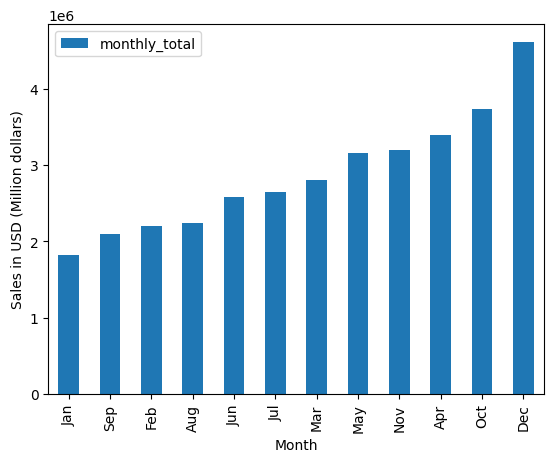

In [83]:
(monthly_highest_sales.toPandas()
 .plot(kind='bar', x='month_ordered', xlabel='Month', ylabel='Sales in USD (Million dollars)'))
plt.show()

### 6. Biggest selling products

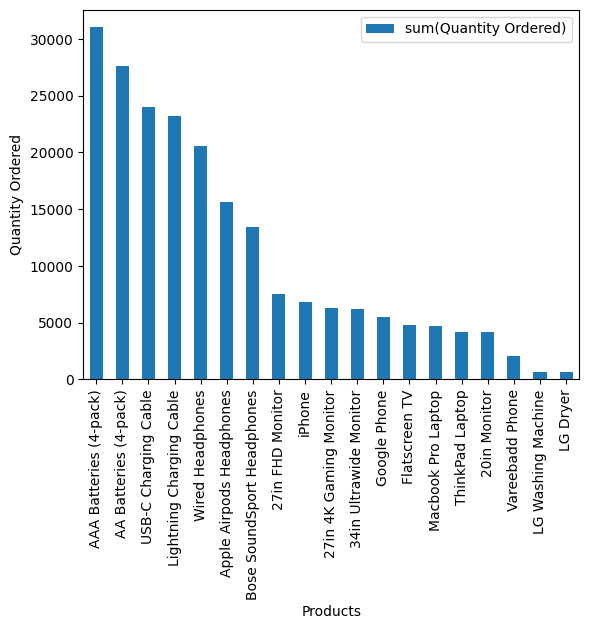

In [84]:
(sales_data_dropna.groupby('Product').agg({'Quantity Ordered': 'sum'})
 .sort("sum(Quantity Ordered)", ascending = False).toPandas().
 plot(kind='bar', x='Product', xlabel='Products', ylabel='Quantity Ordered'))
plt.show()

### 7. Sales during a specific hour (Considered entire year)

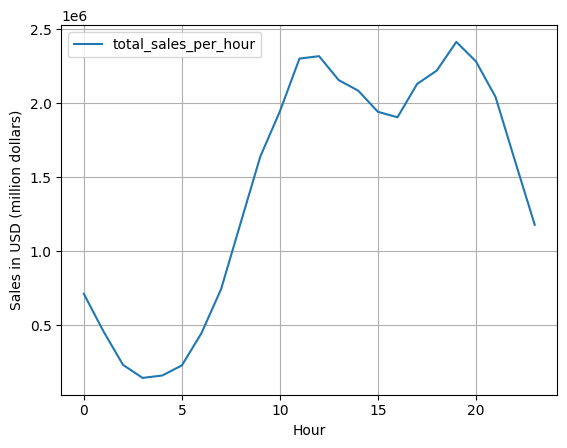

In [110]:
(sales_data_dropna.groupby('hour')
 .sum('total_pay').withColumnRenamed('sum(total_pay)', 'total_sales_per_hour')
 .sort('hour').toPandas().plot(x='hour', xlabel='Hour', ylabel='Sales in USD (million dollars)')
 .grid())

### 8. Find the day of week for entire year which generates maximum revenue.

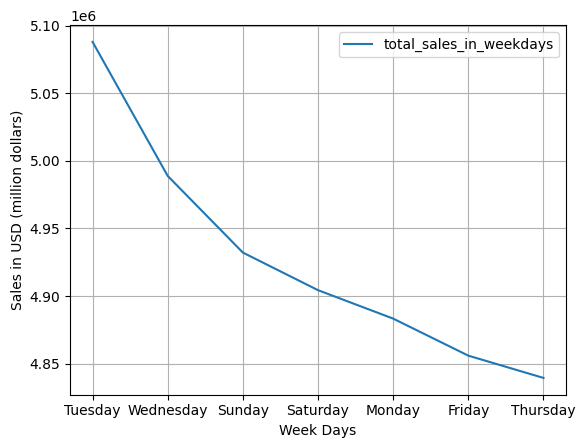

In [111]:
(sales_data_dropna.groupby('day_of_the_week').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_in_weekdays')
 .sort("total_sales_in_weekdays", ascending = False)
 .toPandas().plot(x='day_of_the_week', xlabel='Week Days', ylabel='Sales in USD (million dollars)')
 .grid())

### What are the product sold on `Tuesday`? and How many of each product sold on `Tuesday`?

In [113]:
colmns = ['day_of_the_week']
(sales_data_dropna.groupby('Product').agg(
    funcs.sum(funcs.col('Quantity Ordered')).alias('total_no_of_items_orderd_in_year'),
    *[funcs.first(cl).alias(cl) for cl in colmns]
).where(funcs.col('day_of_the_week') == 'Tuesday')
 .select('Product', 'total_no_of_items_orderd_in_year')
 .sort('total_no_of_items_orderd_in_year', ascending=False).show())

+--------------------+--------------------------------+
|             Product|total_no_of_items_orderd_in_year|
+--------------------+--------------------------------+
|              iPhone|                            6849|
|27in 4K Gaming Mo...|                            6244|
|     ThinkPad Laptop|                            4130|
|        20in Monitor|                            4129|
|  LG Washing Machine|                             666|
+--------------------+--------------------------------+



### Orders with multiple items

In [114]:
multiple_item_id_order = (sales_data_dropna.groupby('Order ID').count().where(funcs.col('count') > 1)
                          .sort('count', ascending=False).withColumnRenamed('count', 'total_item_in_order'))
multiple_item_id_order.count()

7136

In [115]:
sales_data_dropna_tmp = sales_data_dropna
multiple_item_order_data = multiple_item_id_order.join(sales_data_dropna_tmp, ['Order ID'], 'leftouter')
multiple_item_order_data.count()

14649

### 9. What are the products sold together?

In [118]:
multiple_item_order_data_grouped = (multiple_item_order_data.groupby('Order ID')
 .agg(
     funcs.concat_ws(", ", funcs.collect_list(funcs.col('Product'))).alias('items_in_a_order'),
     *[funcs.first(cl).alias(cl) for cl in multiple_item_order_data.columns if not cl == 'Order ID']
 )
)

In [123]:
multiple_item_order_data_grouped.groupby('items_in_a_order').count().sort('count', ascending=False).toPandas().head(10)

,items_in_a_order,count
0,"Lightning Charging Cable, iPhone",882
1,"USB-C Charging Cable, Google Phone",856
2,"Wired Headphones, iPhone",361
3,"USB-C Charging Cable, Vareebadd Phone",312
4,"Wired Headphones, Google Phone",303
5,"Apple Airpods Headphones, iPhone",286
6,"Bose SoundSport Headphones, Google Phone",161
7,"Wired Headphones, Vareebadd Phone",104
8,"Wired Headphones, USB-C Charging Cable, Google...",77
9,"Bose SoundSport Headphones, Vareebadd Phone",60


### Analyzing address column

In [134]:
sales_data_dropna.select("Purchase Address").toPandas()

,Purchase Address
0,"917 1st St, Dallas, TX 75001"
1,"682 Chestnut St, Boston, MA 02215"
2,"669 Spruce St, Los Angeles, CA 90001"
3,"669 Spruce St, Los Angeles, CA 90001"
4,"333 8th St, Los Angeles, CA 90001"
...,...
185945,"840 Highland St, Los Angeles, CA 90001"
185946,"216 Dogwood St, San Francisco, CA 94016"
185947,"220 12th St, San Francisco, CA 94016"
185948,"511 Forest St, San Francisco, CA 94016"


### Defining a function to clean address

In [145]:
def clean_address(address):
    city = address.split(',')[1].strip()
    state = address.split(',')[2].split(' ')[1].strip()
    return f'{city} ({state})'

In [143]:
clean_address(sales_data_dropna.select("Purchase Address").toPandas().iloc[0,0])

'Dallas (TX)'

In [148]:
city_df = sales_data_dropna.toPandas()
city_df["city"] = city_df["Purchase Address"].map(clean_address)
city_df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,hour,minute,day_of_the_week,month_ordered,total_pay,city
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",8,46,Friday,Apr,23.90,Dallas (TX)
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",22,30,Sunday,Apr,99.99,Boston (MA)
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",14,38,Friday,Apr,600.00,Los Angeles (CA)
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",14,38,Friday,Apr,11.99,Los Angeles (CA)
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",9,27,Tuesday,Apr,11.99,Los Angeles (CA)
...,...,...,...,...,...,...,...,...,...,...,...,...
185945,259353,AAA Batteries (4-pack),3,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001",20,56,Tuesday,Sep,8.97,Los Angeles (CA)
185946,259354,iPhone,1,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016",16,0,Sunday,Sep,700.00,San Francisco (CA)
185947,259355,iPhone,1,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016",7,39,Monday,Sep,700.00,San Francisco (CA)
185948,259356,34in Ultrawide Monitor,1,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016",17,30,Thursday,Sep,379.99,San Francisco (CA)


### 10. Cities with highest orders

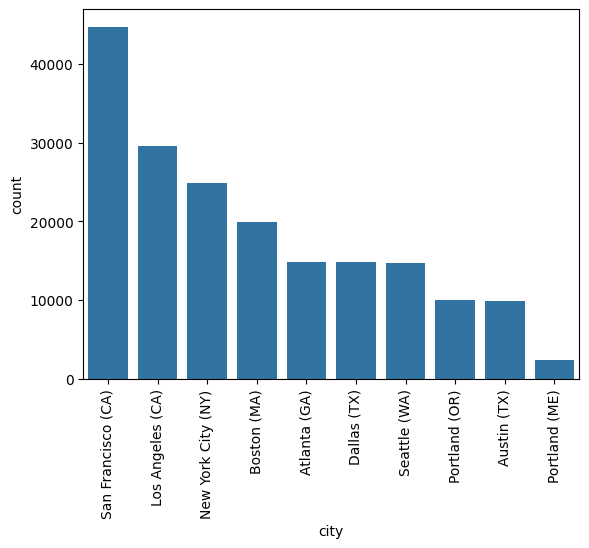

In [161]:
sns.countplot(x = "city", data = city_df, order = city_df.city.value_counts().index)
plt.xticks(rotation= 90)
plt.show()

### 11. Cities with highest revenues

In [187]:
final_df = city_df[["city", "total_pay"]].groupby(["city"]).sum()
final_df.reset_index(inplace = True)
final_df.sort_values("total_pay", ascending= False, inplace = True)

<Figure size 2000x500 with 0 Axes>

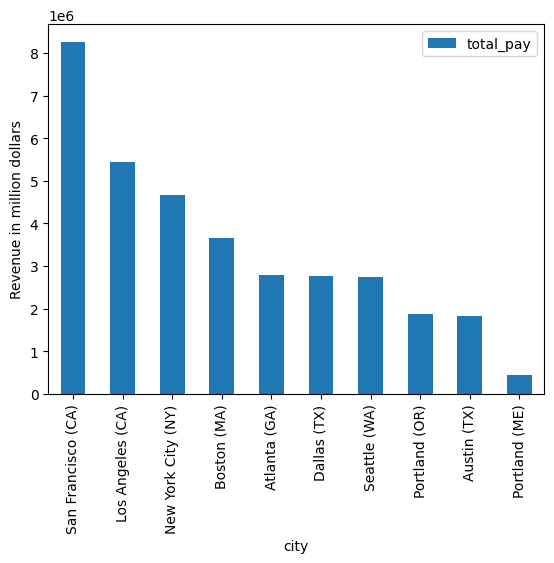

In [195]:
plt.figure(figsize= (20,5))
final_df.plot(x = "city", y = "total_pay", kind = "bar")
plt.xticks(rotation = 90)
plt.ylabel("Revenue in million dollars")
plt.show()